In [28]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from numpy.ma.core import ceil
from scipy.spatial import distance #distance calculation
from sklearn.preprocessing import MinMaxScaler #normalisation
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score #scoring
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib import animation, colors
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

In [29]:
df = pd.read_excel("/Users/alsabbaghs/Downloads/DryBeanDataset/Dry_Bean_Dataset.xlsx")
df["Class"].value_counts()

DERMASON    3546
SIRA        2636
SEKER       2027
HOROZ       1928
CALI        1630
BARBUNYA    1322
BOMBAY       522
Name: Class, dtype: int64

In [30]:
df.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER


In [31]:
def accuracy(confusion_matrix):
   diagonal_sum = confusion_matrix.trace()
   sum_of_all_elements = confusion_matrix.sum()
   return diagonal_sum / sum_of_all_elements

In [32]:
X1 = df.drop("Class", axis = 1)
Y = df["Class"]

scaler = StandardScaler()
X1 = scaler.fit_transform(X1)

Y1 = Y.replace({"DERMASON": 1, "SIRA": 2, "SEKER": 6, "HOROZ": 4, "CALI": 5, "BARBUNYA": 0, "BOMBAY": 3}) #the problem is w cluster 2 and 3 

In [33]:
kmeans1 = KMeans(n_clusters = 7, random_state = 0)
kmeans1.fit(X1)
labels1 = kmeans1.labels_

cm = confusion_matrix(Y1, labels1)
accuracy(cm)

0.7864962162956433

In [4]:
df["Class"] = df["Class"].replace({"DERMASON": 1, "SIRA": 2, "SEKER": 6, "HOROZ": 4, "CALI": 5, "BARBUNYA": 0, "BOMBAY": 3})

In [5]:
X = df.drop("Class", axis = 1)
Y = df["Class"]

In [6]:
#Normalization
def minmax_scaler(data):
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(data)
    return scaled

#Euclidean distance
def e_distance(x, y):
    return distance.euclidean(x, y)

#Manhanttan distance
def m_distance(x, y):
    return distance.cityblock(x, y)

#Best Matching Unit search
def winning_neuron(data, t, som, num_rows, num_cols):
  winner = [0,0]
  shortest_distance = np.sqrt(data.shape[1]) # initialise with max distance
  input_data = data[t]
  for row in range(num_rows):
    for col in range(num_cols):
      distance = e_distance(som[row][col], data[t])
      if distance < shortest_distance: 
        shortest_distance = distance
        winner = [row,col]
  return winner

#Learning rate and neighbourhood range calculation
def decay(step, max_steps,max_learning_rate,max_m_dsitance):
  coefficient = 1.0 - (np.float64(step)/max_steps)
  learning_rate = coefficient*max_learning_rate
  neighbourhood_range = ceil(coefficient * max_m_dsitance)
  return learning_rate, neighbourhood_range



In [7]:
num_rows = 30
num_cols = 30
max_m_dsitance = 7
max_learning_rate = 0.5
max_steps = 50000

#num_nurons = 7 * np.sqrt(X_train.shape[0])
#grid_size = ceil(np.sqrt(num_nurons))
#print(grid_size)

In [8]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
print(principalComponents)

[[-3.51499237e+04 -2.20868414e+01]
 [-3.45863219e+04  5.85865649e+01]
 [-3.37640263e+04 -3.89953729e+01]
 ...
 [-1.56345152e+04 -8.72390530e+01]
 [-1.55590550e+04 -2.40310051e+01]
 [-1.55983141e+04 -7.82400447e+01]]


In [9]:
#mian function

x_norm = minmax_scaler(X) # normalisation
# initialising self-organising map
num_dims = x_norm.shape[1] # numnber of dimensions in the input data
np.random.seed(40)
som = np.random.random_sample(size=(num_rows, num_cols, num_dims)) # map construction

# start training iterations
for step in range(max_steps):
  if (step+1) % 1000 == 0:
    print("Iteration: ", step+1) # print out the current iteration for every 1k
  learning_rate, neighbourhood_range = decay(step, max_steps,max_learning_rate,max_m_dsitance)

  t = np.random.randint(0,high=x_norm.shape[0]) # random index of traing data
  winner = winning_neuron(x_norm, t, som, num_rows, num_cols)
  for row in range(num_rows):
    for col in range(num_cols):
      if m_distance([row,col],winner) <= neighbourhood_range:
        som[row][col] += learning_rate*(x_norm[t]-som[row][col]) #update neighbour's weight

print("SOM training completed")




Iteration:  1000
Iteration:  2000
Iteration:  3000
Iteration:  4000
Iteration:  5000
Iteration:  6000
Iteration:  7000
Iteration:  8000
Iteration:  9000
Iteration:  10000
Iteration:  11000
Iteration:  12000
Iteration:  13000
Iteration:  14000
Iteration:  15000
Iteration:  16000
Iteration:  17000
Iteration:  18000
Iteration:  19000
Iteration:  20000
Iteration:  21000
Iteration:  22000
Iteration:  23000
Iteration:  24000
Iteration:  25000
Iteration:  26000
Iteration:  27000
Iteration:  28000
Iteration:  29000
Iteration:  30000
Iteration:  31000
Iteration:  32000
Iteration:  33000
Iteration:  34000
Iteration:  35000
Iteration:  36000
Iteration:  37000
Iteration:  38000
Iteration:  39000
Iteration:  40000
Iteration:  41000
Iteration:  42000
Iteration:  43000
Iteration:  44000
Iteration:  45000
Iteration:  46000
Iteration:  47000
Iteration:  48000
Iteration:  49000
Iteration:  50000
SOM training completed


In [11]:
label_data = np.array(Y)
map = np.empty(shape=(num_rows, num_cols), dtype=object)


for row in range(num_rows):
  for col in range(num_cols):
    map[row][col] = [] # empty list to store the label

for t in range(x_norm.shape[0]):
  if (t+1) % 1000 == 0:
    print("sample data: ", t+1)
  winner = winning_neuron(x_norm, t, som, num_rows, num_cols)
  #print(winner)
  map[winner[0]][winner[1]].append(label_data[t]) # label of winning neuron


sample data:  1000
sample data:  2000
sample data:  3000
sample data:  4000
sample data:  5000
sample data:  6000
sample data:  7000
sample data:  8000
sample data:  9000
sample data:  10000
sample data:  11000
sample data:  12000
sample data:  13000


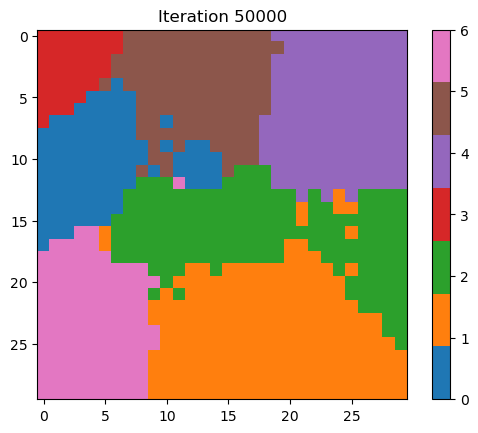

In [12]:
num_colors = 7
label_map = np.zeros(shape=(num_rows, num_cols),dtype=np.int64)
for row in range(num_rows):
  for col in range(num_cols):
    label_list = map[row][col]
    if len(label_list)==0:
      label = 2
    else:
      label = max(label_list, key=label_list.count)
    label_map[row][col] = label

title = ('Iteration ' + str(max_steps))
cmap = cmap = colors.ListedColormap(colors=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink'][:num_colors])
plt.imshow(label_map, cmap=cmap)
plt.colorbar()
plt.title(title)
plt.show()

In [13]:
# test data

# using the trained som, search the winning node of corresponding to the test data
# get the label of the winning node

data = minmax_scaler(X) # normalisation

winner_labels = []

for t in range(data.shape[0]):
 winner = winning_neuron(data, t, som, num_rows, num_cols)
 row = winner[0]
 col = winner[1]
 predicted = label_map[row][col]
 winner_labels.append(predicted)

print("Accuracy: ",accuracy_score(Y, np.array(winner_labels)))

Accuracy:  0.9124972448754683


In [14]:
cm = confusion_matrix(Y, np.array(winner_labels))
cm

array([[1131,    0,   35,    1,    6,  134,   15],
       [   0, 3213,  272,    0,    6,    0,   55],
       [   8,  235, 2310,    0,   41,    5,   37],
       [   0,    0,    0,  522,    0,    0,    0],
       [   0,   17,   41,    0, 1846,   24,    0],
       [  77,    0,   18,    1,   43, 1486,    5],
       [   6,   39,   69,    0,    1,    0, 1912]])

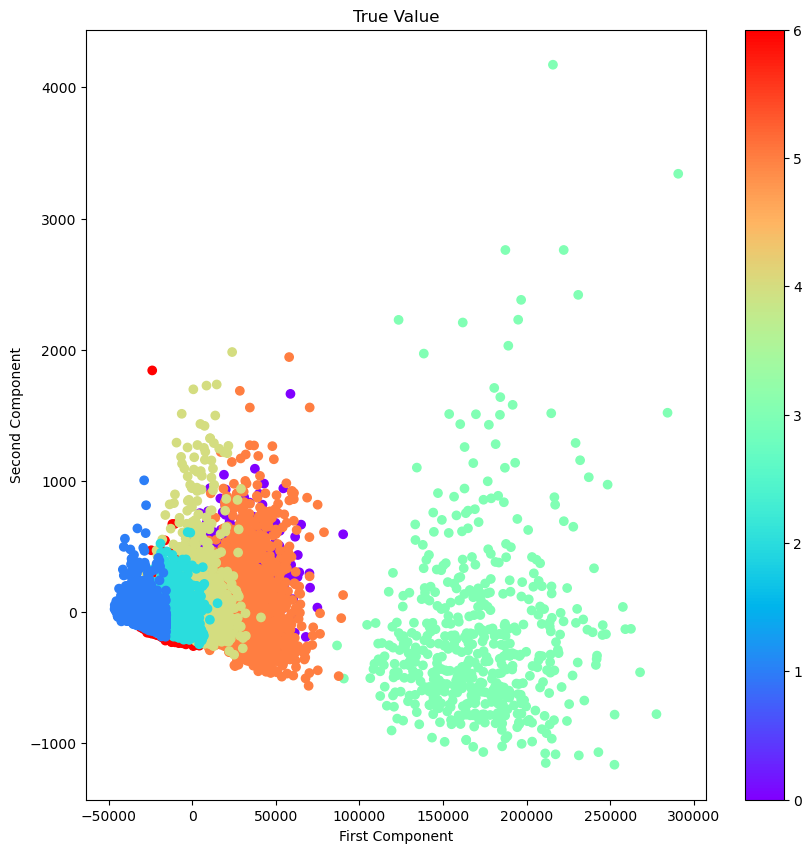

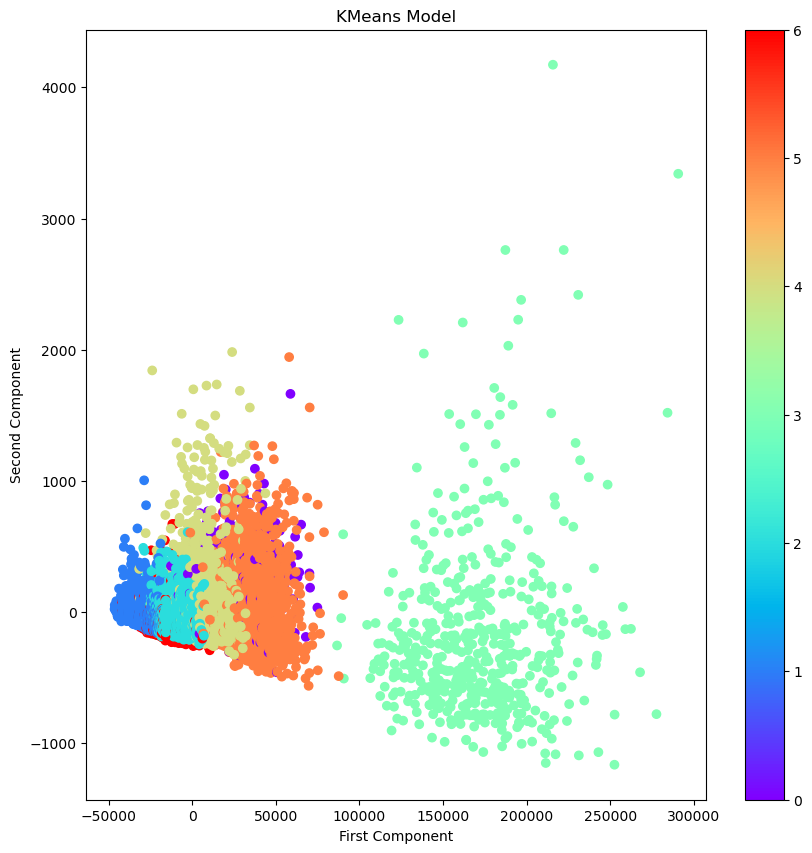

In [15]:
fig, ax = plt.subplots(figsize=(10, 10))
scatter = ax.scatter(principalComponents[:, 0], principalComponents[:, 1], c = Y, cmap='rainbow')
plt.xlabel('First Component')
plt.ylabel('Second Component')
plt.title('True Value')
plt.colorbar(scatter)
plt.show()

fig, ax = plt.subplots(figsize=(10, 10))
scatter = ax.scatter(principalComponents[:, 0], principalComponents[:, 1], c = np.array(winner_labels), cmap='rainbow')
plt.xlabel('First Component')
plt.ylabel('Second Component')
plt.title('KMeans Model')
plt.colorbar(scatter)
plt.show()